function_code_of_JTM

In [1]:
import numpy as np
import csv, math, numpy
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from os import listdir
from os.path import isfile, join
from PIL import Image
import time

In [2]:
def readfile(path):
    fichiers = [f for f in listdir(path) if isfile(join(path, f)) ]
    return fichiers

In [3]:
def readJointsFromCad60( path,nbJointure):

    f = open(path, "r") #ouvrir le fichier 
    T = np.zeros(0)     #initialiser une matrice par zeros 
    nbLine = 0          #initialiser nombre de ligne 
    tabMask=[False,False,False,False,False,False,False,False,False,False,False,True,True,True, 
         False,False,False,False,False,False,False,False,False,False,False,True,True,True, 
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True, 
         False,False,False,False,False,False,False,False,False,False,False,True,True,True, 
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,False,False,False,False,False,False,False,False,False,False,True,True,True,
         False,True,True,True, 
         False,True,True,True,
         False,True,True,True,
         False,True,True,True,False] #Masque pour extraire les valeurs souhaitées

    for ligne in f:
        if ligne == "END": # si ligne egale à END sortir du fichier 
            break
        ligne = ligne.replace(",\n", "")  # remplacere ",/n" par le vide 
        mots = np.array(ligne.split(",") ,dtype=np.float) # Séparation en ligne  pour extrarire les valeurs   
        x = mots[tabMask]      #les valeurs souhaitées (les coordonnées de jointures pour tout les frames )
        T = np.append(T, x)    #remplir la matrice par les valeurs
        nbLine += 1              
    
    T = np.reshape(T, (nbLine,15,-1)) #Tensor final 

    return T

In [4]:
def calcul_speed(T):
    V = np.zeros((T.shape[0],T.shape[1]))#initialiser une matrice de vitesse suivant X par zeros 
    vitesse_norme = np.zeros((T.shape[0],15))
    for j in range(0,T.shape[1]):
        for i in range(0,T.shape[0]-1,1):
            V[i+1][j] =  T[:,j][i+1]-T[:,j][i] 
            Max_vitesse=np.amax(V[:,j])
            vitesse_norme[:,j]=V[:,j]/Max_vitesse
    return vitesse_norme

In [5]:
def get_speed(T):
    np.seterr(divide='ignore', invalid='ignore')
    Tx = T[:, :, 0]#la coordonnée X pour tout les jointure (All  Frame)
    Ty = T[:, :, 1]#la coordonnée Y pour tout les jointure (All  Frame)
    Tz = T[:, :, 2]#la coordonnée Z pour tout les jointure (All  Frame)
    #calcule de la vitesse suivant l'axe X---------------------------------------------------------
    Vx=calcul_speed(Tx)
    Vy=calcul_speed(Ty)
    Vz=calcul_speed(Tz)
    #calcule de la Vitess---------------------------------------------------------------------------------
    V = np.sqrt(pow(Vx,2)+pow(Vy,2)+pow(Vz,2)) # vitesse = racine(Vx^2+Vy^2+Vz^2)
    return V

In [6]:
def get_HSV__RGB(V):
    
    V_max=np.amax(V) # normalisation de la vitesse
    smin=np.amax(V/V_max)#la saturation min
    smax=np.amin(V/V_max) #la saturation max
    bmin=np.amax(V/V_max) #luminosité min
    bmax=np.amin(V/V_max) #luminosité min 
    
    nbJoint=V.shape[1]
    nbFrame=V.shape[0]
    
    HSV = np.zeros((nbJoint, nbFrame, 3)) #initialer la matrice HSV par zeros    
    RGB = np.zeros(HSV.shape)  #initialer la matrice RGB par zeros
    #génerer la matrice de teinte ---------------------------------------------------------------------
    H=np.arange(1,V.shape[0]+1)
    H_norme=H/np.amax(H)
    #génerer la matrice de saturation -----------------------------------------------------------------
    S=(V/V_max)*(smax-smin)+smin
    S_norme=S/np.amax(S)
    #génerer la matrice de luminosité -----------------------------------------------------------------
    B=(V/V_max)*(bmax-bmin)+bmin
    B_norme=B/np.amax(B)

    #génerer la matrice HSV par la concaténation du teinte, saturation et luminosité -------------------   
    for i in range(nbJoint):
        HSV[i] = np.column_stack((H_norme,  S_norme[:, i], B_norme[:, i]))
    #génerer la matrice RGB (convertir HSV à RGB )         
    for i in range(nbJoint):
        RGB[i] = clr.hsv_to_rgb(HSV[i]) 
    return (HSV,RGB)


In [7]:
def Rotation (T, theta, phy):
    '''
    XT = (N frame x K joints x XYZ)
    '''  
    nbLine = 0 
    R=np.zeros(0)
    ct, st = np.cos(theta), np.sin(theta)
    cf, sf = np.cos(phy), np.sin(phy)

    Rteta = np.matrix([[ct,0,st],
                       [0,1,0],
                       [-st,0,ct]])
    Rphy= np.matrix([[cf,-sf,0],
                     [sf, cf,0],
                     [0,0,1]])
    Rt_f=Rteta.dot(Rphy)
    for i in range(T.shape[1]):
        position = np.reshape(T[:,i,:],(3,T.shape[0]))
        D= Rt_f.dot(position)
        R =np.append(R, np.reshape(D,(T.shape[0],3)))
        nbLine += 1       
    R = np.reshape(R, (T.shape[0],nbLine,-1))                   
    
    RX=R[:,:,0]
    RY=R[:,:,1]
    RZ=R[:,:,2]
    
    return (RX,RY,RZ)

In [8]:
def rotateJoints(joints, thetaZDeg, phyYDeg, verbose = False):
    '''
    Return the rotated joints
    joints shape is (#nbFrame, #numJoints, #XYZ)
    
    '''
    phyY = np.radians(phyYDeg)
    cosPhyY, sinPhyY = np.cos(phyY), np.sin(phyY)
    Ry = np.array(( (cosPhyY, 0, sinPhyY),
                    (0,1,0),
                    (-sinPhyY,0, cosPhyY)))
    
    thetaZ = np.radians(thetaZDeg)
    cosThetaZ, sinThetaZ = np.cos(thetaZ), np.sin(thetaZ)
    Rz = np.array(( (cosThetaZ, -sinThetaZ, 0),
                    (sinThetaZ,cosThetaZ,0),
                    (0, 0, 1)))
    
   # Rz = np.array(( (cosPhyY, -sinPhyY, 0),
   #                 (sinPhyY,cosPhyY,0),
   #                 (0, 0, 1)))
    if(verbose):
        print("Rz")
        print(Rz)
    if(verbose):
        print("Ry")
        print(Ry)
    jointsShape = joints.shape
    # transform in two dimension matrix to be able to do the rotation 
    # dim N x 3
    jointsReshape = joints.reshape((jointsShape[0]*jointsShape[1],jointsShape[2]) )
    
    
    RyRz = np.matmul(Ry, Rz)
    
    if(verbose):
        print("RyRz")
        print(RyRz)
    
    # jointsReshape.T is a 3 x N vector instead of Nx3 
    # in order to do the RzRy (3x3) matmul
    jointsReshape = np.matmul(RyRz, jointsReshape.T).T
   

    
    return jointsReshape.reshape((jointsShape[0], jointsShape[1],jointsShape[2]))

In [9]:
T = np.array([ 
    [  # Frame1,
        [1,0,0], #joint 1 pos
        [2,0,0] #joint 2 pos
    ],
    [   # Frame2,
        [0,1,0], #joint 1 pos
        [0,2,0] #joint 2 pos
    ],
    [   # Frame3,
        [0,0,1], #joint 1 pos
        [0,0,2] #joint 2 pos
    ]

])
TrotVHD = rotateJoints(T, 30,30, True)
print("thetaZ 0 phyY 0")
print(T)
print("thetaZ 30 phyY 0")
print(rotateJoints(T, 30,0, True))
print("thetaZ 0 phyY 30")
print(rotateJoints(T, 0,30, True))
print("thetaZ 30 phyY 30")
print(rotateJoints(T, 30,30, True))

(TrotX, TrotY, TrotZ) = (TrotVHD[:,:,0], TrotVHD[:,:,1], TrotVHD[:,:,2])
print(TrotX)
print(TrotY)
print(TrotZ)


TrotASE = Rotation(T, 30, 15)
print(TrotASE)
np.cos(np.deg2rad(30))

Rz
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Ry
[[ 0.8660254  0.         0.5      ]
 [ 0.         1.         0.       ]
 [-0.5        0.         0.8660254]]
RyRz
[[ 0.75      -0.4330127  0.5      ]
 [ 0.5        0.8660254  0.       ]
 [-0.4330127  0.25       0.8660254]]
thetaZ 0 phyY 0
[[[1 0 0]
  [2 0 0]]

 [[0 1 0]
  [0 2 0]]

 [[0 0 1]
  [0 0 2]]]
thetaZ 30 phyY 0
Rz
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Ry
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
RyRz
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
[[[ 0.8660254   0.5         0.        ]
  [ 1.73205081  1.          0.        ]]

 [[-0.5         0.8660254   0.        ]
  [-1.          1.73205081  0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          2.        ]]]
thetaZ 0 phyY 30
Rz
[[ 1. -0.  0.]
 [ 0.  

0.8660254037844387

In [10]:
def resize_image(idx,N_plan,theta,phy,size):
    save_results_to_xy='datasets/CAD-60-Images/'+N_plan+'/'+'NumGest'+str(idx+1)+'theta='+str(theta)+'phy='+str(phy)+ '.png'
#------------------------------------------resize image plan 
    im_xy=Image.open(save_results_to_xy)
    pil_resize_xy = im_xy.resize( size )        
    pil_resize_xy.save(save_results_to_xy)


In [11]:
def plotJTM_plan(ax1,ax2,N_plan,theta,phy,idx,RGB,size):
    fig,ax = plt.subplots()
    for i in range(15):
        xy=ax.scatter(ax1[:, i],ax2[:, i],c=RGB[i]) # plan xy  
        plt.axis('off')
        plt.savefig('datasets/CAD-60-Images/'+N_plan+'/'+'NumGest'+str(idx+1)+'theta='+str(theta)+'phy='+str(phy)+ '.png')
    plt.close(fig)
    plt.rcParams.update({'figure.max_open_warning': 0})

In [12]:
def plotJTM(T,idx,size): #idx: correspond le geste 
    V=get_speed(T)
    [HSV,RGB]=get_HSV__RGB(V)
    # faire la boucle sur theta et phy
    # puis enregistrer le fichier obtenu à chaque angle
    # convention de nommage du fichier "{NumGest}_{Theta}_{Phy}.png"
    #DESSINER LES JTM pour chaque plan
    #resize a chaque plan
    for phy in range(-45,50,15):
        for theta in range(0,50,15):
            Trot = rotateJoints(T, theta, phy)
            #(TrotX, TrotY, TrotZ) = Rotation(T, theta, phy)                        
            (TrotX, TrotY, TrotZ) = (Trot[:,:,0], Trot[:,:,1], Trot[:,:,2])
            plotJTM_plan(TrotX, TrotY, "XY",theta,phy ,idx, RGB, size) # a développer
            resize_image(idx,"XY",theta,phy,size)
            plotJTM_plan(TrotX, TrotZ, "XZ" ,theta,phy ,idx, RGB, size) # a développer
            resize_image(idx,"XZ",theta,phy,size)
            plotJTM_plan(TrotY, TrotZ, "YZ" ,theta,phy ,idx, RGB, size) # a développer
            resize_image(idx,"YZ",theta,phy,size)                      
            #print("process "+str(phy)+" t:"+str(theta))
    #print("end")

In [13]:
def time_execution(dur):
    if(dur>3600):
        heurs=int(dur/3600)
        dur=dur%3600
    if(dur>60):
        minut=int(dur/60)
        dur=dur%60
    print(heurs,"heurs",minut,"minut")

In [14]:
def main():
    t1 = time.clock();
    size = [256, 256]
    A=np.zeros(0)
    Dossier_DataSet='datasets/CAD-60'
    fichiers = readfile(Dossier_DataSet)   
    for i in range(len(fichiers)):        
        A=readJointsFromCad60(Dossier_DataSet+'/'+fichiers[i],15)
        plotJTM(A,i,size)
       
    
    dur=time.clock()-t1
    time_execution(dur)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


PermissionError: [Errno 13] Permission denied: 'datasets/CAD-60-Images/XY/NumGest5theta=15phy=0.png'

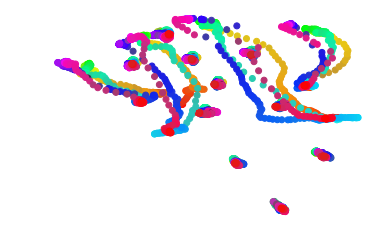

In [16]:
main()